# Progressive Inference for Music Demixing ID: L12
Description: Using denoising diffusion approaches to train music demixing (MDX) models is
promising but requires retraining large and carefully tuned neural networks (Plaja-Roglans,
2022). Instead, we will explore a related yet different approach: can we improve separation
quality solely by scheduling the inference process using a diffusion-inspired strategy even
without retraining? By experimenting with existing MDX models (Spleeter by Deezer,Meta’s Demucs, ByteDance’s BS-Roformer, etc.), this project offers an exciting opportunity
to explore and possibly enhance the performance of state-of-the-art AI techniques.

**Resources**


(Plaja-Roglans, 2022) https://ismir2022program.ismir.net/poster_262.html
Denoising Diffusion Probabilistic Models: https://arxiv.org/abs/2006.11239
MDX Challenge 2021: https://arxiv.org/abs/2108.13559
MDX Challenge 2023: https://arxiv.org/abs/2308.06979
Overview of state-of-the-art MDX models:
https://paperswithcode.com/sota/music-source-separation-on-musdb18-hq

### Preliminary step: Install and Import Libraries.

In [75]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [76]:
import IPython
import torch
import torchaudio
import os
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import librosa
from torchmetrics.audio import ScaleInvariantSignalDistortionRatio

### Loading of the Model and Device Selection

In [77]:
bundle = torchaudio.pipelines.HDEMUCS_HIGH_MUSDB_PLUS
model = bundle.get_model()
sample_rate = bundle.sample_rate

cpu_device = torch.device("cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # windows
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # macOS
model.to(device)

HDemucs(
  (freq_encoder): ModuleList(
    (0): _HEncLayer(
      (conv): Conv2d(4, 48, kernel_size=(8, 1), stride=(4, 1), padding=(2, 0))
      (norm1): Identity()
      (rewrite): Conv2d(48, 96, kernel_size=(1, 1), stride=(1, 1))
      (norm2): Identity()
      (dconv): _DConv(
        (layers): ModuleList(
          (0): Sequential(
            (0): Conv1d(48, 12, kernel_size=(3,), stride=(1,), padding=(1,))
            (1): GroupNorm(1, 12, eps=1e-05, affine=True)
            (2): GELU(approximate='none')
            (3): Conv1d(12, 96, kernel_size=(1,), stride=(1,))
            (4): GroupNorm(1, 96, eps=1e-05, affine=True)
            (5): GLU(dim=1)
            (6): _LayerScale()
          )
          (1): Sequential(
            (0): Conv1d(48, 12, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
            (1): GroupNorm(1, 12, eps=1e-05, affine=True)
            (2): GELU(approximate='none')
            (3): Conv1d(12, 96, kernel_size=(1,), stride=(1,))
           

Device Check:

In [78]:
device

device(type='mps')

### Loading of the Dataset and Dataset Preparation

Download the dataset at: https://zenodo.org/records/3338373

Global variables:

In [79]:
SEGMENT_LENGTH = 30  # 30 seconds of audio from each song
DATASET_FOLDER =  "./musdb18hq/test" # dataset should be inside the project folder

Dictionary creation

(Dataset Structure: `{track_folder -> {stem_name -> waveform}`)


In [80]:
def get_max_non_silence_start(song):
    """
    Given a song (dictionary of stem names -> waveform),
    use librosa.effects.trim to find the starting index of non-silent 
    segments for each stem and return the highest start index.
    """
    max_start = 0
    for stem, waveform in song.items():
        # Convert tensor waveform to numpy if necessary
        if hasattr(waveform, "detach"):
            waveform_np = waveform.detach().cpu().numpy()
        else:
            waveform_np = waveform
        
        # If waveform is multi-channel (shape: channels x samples)
        if waveform_np.ndim > 1:
            # Convert to mono using librosa.to_mono
            waveform_np = librosa.to_mono(waveform_np)
        else:
            waveform_np = waveform_np.squeeze()

        # Trim leading and trailing silence
        # trim returns a tuple (trimmed_audio, (start, end))
        trimmed, indices = librosa.effects.trim(waveform_np)
        if indices.size and indices[0] > max_start:
            max_start = indices[0]
            
    return max_start

In [81]:
def is_stem_silent(waveform, threshold=1e-4):
    """
    Determines if a given song stem is not silent.
    
    Args:
        waveform (torch.Tensor or np.ndarray): The audio waveform of the stem.
        threshold (float): The amplitude threshold below which the stem is considered silent.
    
    Returns:
        bool: True if the stem is not silent, False otherwise.
    """
    # Convert tensor waveform to numpy if necessary
    if hasattr(waveform, "detach"):
        waveform = waveform.detach().cpu().numpy()
    
    # If waveform is multi-channel (shape: channels x samples), convert to mono
    if waveform.ndim > 1:
        waveform = librosa.to_mono(waveform)
    
    # Check if the maximum absolute amplitude exceeds the threshold
    return np.max(np.abs(waveform)) < threshold

In [82]:
def load_and_process_dataset():
    """
    Load the dataset from the specified folder.
    Each subfolder in the dataset corresponds to a song.
    Each song contains multiple stems (e.g., mixture, drums, bass, etc.).
    Returns:
        dataset_dict (dict): A dictionary where keys are track folders and values are dictionaries of stems.
    """

    # sorted list of folders in the dataset
    track_folders = sorted(
        folder for folder in os.listdir(DATASET_FOLDER)
        if os.path.isdir(os.path.join(DATASET_FOLDER, folder))
    )

    # Dictionary to store {track_folder -> {stem_name -> waveform}}
    dataset_dict = {}

    # Each subfolder in musdb18hq/test corresponds to a song
    for track_folder in track_folders:
        track_path = os.path.join(DATASET_FOLDER, track_folder)
        if not os.path.isdir(track_path):
            continue

        # Prepare a sub-dictionary for this song
        stems_dict = {}
        stem_names = ["mixture", "drums", "bass", "vocals", "other"]
        
        for stem_name in stem_names:
            file_path = os.path.abspath(os.path.join(track_path, f"{stem_name}.wav"))
            
            if not os.path.isfile(file_path):
                print(f"Warning: file not found {file_path}")
                continue

            # Load full audio
            print(f"Loading {track_folder}" + f" - {stem_name}")
            waveform, sr = torchaudio.load(file_path)

            stems_dict[stem_name] = waveform
        
        max_start = get_max_non_silence_start(stems_dict)

        # If the stem is silent, remove it from the dictionary else trim it
        for stem_name, waveform in stems_dict.items():
            if is_stem_silent(waveform) or waveform.shape[1] < SEGMENT_LENGTH * sample_rate + max_start:
                print(f"Removing silent stem: {stem_name}")
                del stems_dict[stem_name]
            else:
                # Trim the waveform to the max_start to segment samples
                duration = SEGMENT_LENGTH * sample_rate + max_start
                stems_dict[stem_name] = waveform[:, max_start:duration]

        dataset_dict[track_folder] = stems_dict

    return dataset_dict

In [83]:
def load_dataset():
    """
    Load the dataset from the musdb18hq_trimmed folder.
    Each subfolder in the dataset corresponds to a song.
    Each song contains multiple stems (e.g., mixture, drums, bass, etc.).
    Returns:
        dataset_dict (dict): A dictionary where keys are track folders and values are dictionaries of stems.
    """
    dataset_dict = {}

    for track_folder in os.listdir("musdb18hq_trimmed"):
        track_path = os.path.join("musdb18hq_trimmed", track_folder)
        if not os.path.isdir(track_path):
            continue

        # Prepare a sub-dictionary for this song
        stems_dict = {}
        
        for stem_name in ["mixture", "drums", "bass", "vocals", "other", "new_mixture"]:
            file_path = os.path.abspath(os.path.join(track_path, f"{stem_name}.wav"))
            
            if not os.path.isfile(file_path):
                print(f"Warning: file not found {file_path}")
                continue

            # Load full audio
            waveform, sr = torchaudio.load(file_path)

            stems_dict[stem_name] = waveform
            
        dataset_dict[track_folder] = stems_dict
        
    return dataset_dict

Function that creates the new mixture and save it in the dictionary

In [84]:
def create_dataset(dataset_dict):
    """
    Create a dataset of trimmed audio files from the musdb18hq dataset.
    The dataset is saved in the musdb18hq_trimmed folder.
    """
    for track_folder, stems_dict in dataset_dict.items():
    
        track_path = os.path.join("musdb18hq_trimmed", track_folder)
        os.makedirs(track_path, exist_ok=True)
        
        # Add new_mixture file to the track folder as the sum of the stems
        new_mixture = torch.zeros((2, SEGMENT_LENGTH * sample_rate))
        for stem_name, waveform in stems_dict.items():
            
            file_path = os.path.join(track_path, f"{stem_name}.wav")
            torchaudio.save(file_path, waveform, sample_rate=sample_rate)

            # Generation of the new_mixture file
            if stem_name != "mixture":
                new_mixture += waveform*0.25
        
        # Trim the new_mixture to the desired length
        new_mixture = new_mixture[:, :SEGMENT_LENGTH * sample_rate]
        new_mixture_path = os.path.join(track_path, "new_mixture.wav")
        torchaudio.save(new_mixture_path, new_mixture, sample_rate)
        #print(f"Saved new mixture to {new_mixture_path}")
        
        # Add the new_mixture to stems_dict and update dataset_dict
        stems_dict["new_mixture"] = new_mixture
        dataset_dict[track_folder] = stems_dict  # Update the dataset_dict explicitly
        #print(f"Added new_mixture to stems_dict for track {track_folder}")

In [85]:
if os.path.isdir("musdb18hq_trimmed"):
    print("Dataset already exists.")
    # Load the trimmed dataset
    dataset_dict = load_dataset()
    print("Dataset loaded.")
else:
    print("Loading dataset...")
    dataset_dict = load_and_process_dataset()
    print("Dataset loaded.")
    
    # Save the trimmed dataset
    os.makedirs("musdb18hq_trimmed", exist_ok=True)
    create_dataset(dataset_dict)

    print("Trimmed dataset saved.")

Dataset already exists.
Dataset loaded.


Trimmed tracks check

In [86]:
print("Number of keys in dataset_dict:", len(dataset_dict))

# Check the first track folder and its contents
first_track_folder = list(dataset_dict.keys())[0]
print("First track folder:", first_track_folder)
print("Contents of the first track folder:")
for stem_name in dataset_dict[first_track_folder].keys():
    print(f" - {stem_name}: {dataset_dict[first_track_folder][stem_name].shape}")


Number of keys in dataset_dict: 50
First track folder: Moosmusic - Big Dummy Shake
Contents of the first track folder:
 - mixture: torch.Size([2, 1323000])
 - drums: torch.Size([2, 1323000])
 - bass: torch.Size([2, 1323000])
 - vocals: torch.Size([2, 1323000])
 - other: torch.Size([2, 1323000])
 - new_mixture: torch.Size([2, 1323000])


Function to separate the sources


In [87]:
def separate_sources(
    model,
    mix,
    segment=30,
    overlap=0.0,  # set to 0.0 to avoid chunk repetition
    device=None
):
    """
    Apply model to a given mixture. Use fade, and add segments together in order to add model segment by segment.

    Args:
        segment (int): segment length in seconds
        device (torch.device, str, or None): if provided, device on which to
            execute the computation, otherwise `mix.device` is assumed.
            When `device` is different from `mix.device`, only local computations will
            be on `device`, while the entire tracks will be stored on `mix.device`.
    """

    if device is None:
        device = mix.device
    else:
        device = torch.device(device)

    batch, channels, length = mix.shape

    # chunk_len for entire 30s, no overlap
    chunk_len = int(sample_rate * segment * (1 + overlap))  # effectively 30s if overlap=0
    start = 0
    end = chunk_len

    overlap_frames = int(overlap * sample_rate)
    fade = torchaudio.transforms.Fade(fade_in_len=0, fade_out_len=overlap_frames, fade_shape="linear")

    # Prepare final buffer
    final = torch.zeros(batch, len(model.sources), channels, length, device=device)

    while start < length - overlap_frames:
        chunk = mix[:, :, start:end]
        with torch.no_grad():
        
            # chunk = chunk.to(device)

            out = model(chunk).to(device)
            # out = out.to(device)
            
        out = fade(out)
        final[:, :, :, start:end] += out

        if start == 0:
            fade.fade_in_len = overlap_frames
            start += chunk_len - overlap_frames
        else:
            start += chunk_len
        end += chunk_len
        if end >= length:
            fade.fade_out_len = 0

    return final

Save the new DATASET FOLDER

In [88]:
# New dataset folder
DATASET_FOLDER_TRIMMED = "./musdb18hq_trimmed"

Evaluation of the results

In [89]:
def evaluate_sdr(original_stem: torch.Tensor, predicted_stem: torch.Tensor, device: torch.device=None):
    """
    Calculate the Scale-Invariant Signal-to-Distortion Ratio (SDR) between the original and predicted stems.

    Args:
        original_stem (torch.Tensor): The original stem waveform (shape: [channels, samples]).
        predicted_stem (torch.Tensor): The predicted stem waveform (shape: [channels, samples]).

    Returns:
        float: The SDR value.
    """
    # Ensure both tensors are on the same device
    original_stem.to(device)
    predicted_stem.to(device)
    
    # Initialize the SDR metric
    sdr_metric = ScaleInvariantSignalDistortionRatio().to(device)

    # Compute the SDR
    sdr_value = sdr_metric(predicted_stem, original_stem).item()

    return sdr_value

Evaluation of the model in standard usage

In [90]:
def evaluate_sdr_across_dataset(dataset_dict, model, segment_length, device):
    """
    Separates and evaluates the SDR for each stem (bass, drums, vocals, other) across all tracks in the dataset.

    Args:
        dataset_dict (dict): Dictionary containing the dataset with track folders and their stems.
        model (torch.nn.Module): The source separation model.
        segment_length (int): Length of the audio segment in seconds.
        device (torch.device): The device to run the model on.

    Returns:
        dict: A dictionary containing the average SDR for each stem.
    """
    sdr_results = {stem: [] for stem in ["bass", "drums", "vocals", "other"]}

    for track_name, stems_dict in dataset_dict.items():
        print(f"Processing track: {track_name}")

        # Ensure the mixture exists in the stems
        if "new_mixture" not in stems_dict:
            print(f"Skipping track {track_name} as it does not contain a new mixture.")
            continue

        # Load the mixture and move it to the correct device
        mixture = stems_dict["new_mixture"].to(device).unsqueeze(0)  # Add batch dimension
        
        # Perform source separation
        separated_sources = separate_sources(model, mixture, segment=segment_length, device=device)

        # Evaluate SDR for each stem
        for i, stem_name in enumerate(model.sources):
            if stem_name in stems_dict:
                original_stem = stems_dict[stem_name].to(device)
                predicted_stem = separated_sources[0, i].to(device)

                # Calculate SDR
                sdr_value = evaluate_sdr(original_stem, predicted_stem, device=device)
                sdr_results[stem_name].append(sdr_value)
                print(f"SDR for {stem_name} in track {track_name}: {sdr_value:.2f} dB")

    # Calculate the average SDR for each stem
    average_sdr = {stem: (np.mean(values) if values else None) for stem, values in sdr_results.items()}

    print("\nAverage SDR for each stem:")
    for stem, avg_sdr in average_sdr.items():
        print(f"{stem}: {avg_sdr:.2f} dB" if avg_sdr is not None else f"{stem}: No data")

    return average_sdr

Testing the effect of the volume on the SDR on the same stem

In [91]:
track_names = list(dataset_dict.keys())

track_chosen = track_names[25]

# Retrieve the original "new_mixture" waveform from the specified track
original_stem = dataset_dict[track_chosen]["vocals"]

# Create a new version with a different volume 
different_vol_stem = original_stem * 0.6

print(f"Original stem shape: {original_stem.shape}")
print(f"Different volume stem shape: {different_vol_stem.shape}")

# Evaluate SDR when comparing the original stem to itself 
sdr_original = evaluate_sdr(original_stem, original_stem)

# Evaluate SDR when comparing the scaled stem to the original
sdr_different = evaluate_sdr(original_stem, different_vol_stem)

print(f"SDR for original volume vs. itself: {sdr_original:.2f} dB")
print(f"SDR for different volume vs. original: {sdr_different:.2f} dB")

Original stem shape: torch.Size([2, 1323000])
Different volume stem shape: torch.Size([2, 1323000])
SDR for original volume vs. itself: 105.44 dB
SDR for different volume vs. original: 101.00 dB


Function to plot the average SDR across all the stems in the dataset

In [92]:
def plot_sdr_results(sdr_results):
    """
    Plot the SDR results for each stem.

    Args:
        sdr_results (dict): Dictionary containing the average SDR for each stem.
    """
    stems = list(sdr_results.keys())
    sdr_values = [sdr_results[stem] for stem in stems]

    plt.figure(figsize=(10, 5))
    plt.bar(stems, sdr_values, color=['blue', 'orange', 'green', 'red'])
    plt.xlabel('Stem')
    plt.ylabel('Average SDR (dB)')
    plt.title('Average SDR for Each Stem')
    plt.ylim([0, max(sdr_values) + 5])
    plt.grid(axis='y')
    plt.show()

In [93]:
# Evaluate SDR across the dataset using the provided function.
average_sdr = evaluate_sdr_across_dataset(dataset_dict, model, SEGMENT_LENGTH, device)
print("Average SDR results per stem:", average_sdr)

Processing track: Moosmusic - Big Dummy Shake
SDR for drums in track Moosmusic - Big Dummy Shake: 10.66 dB
SDR for bass in track Moosmusic - Big Dummy Shake: 10.10 dB
SDR for other in track Moosmusic - Big Dummy Shake: 7.11 dB
SDR for vocals in track Moosmusic - Big Dummy Shake: 11.06 dB
Processing track: The Mountaineering Club - Mallory
SDR for drums in track The Mountaineering Club - Mallory: 14.67 dB
SDR for bass in track The Mountaineering Club - Mallory: 10.87 dB
SDR for other in track The Mountaineering Club - Mallory: 6.30 dB
SDR for vocals in track The Mountaineering Club - Mallory: 13.20 dB
Processing track: Bobby Nobody - Stitch Up
SDR for drums in track Bobby Nobody - Stitch Up: 8.64 dB
SDR for bass in track Bobby Nobody - Stitch Up: 9.46 dB
SDR for other in track Bobby Nobody - Stitch Up: 5.80 dB
SDR for vocals in track Bobby Nobody - Stitch Up: 10.13 dB
Processing track: Punkdisco - Oral Hygiene
SDR for drums in track Punkdisco - Oral Hygiene: 16.67 dB
SDR for bass in tra

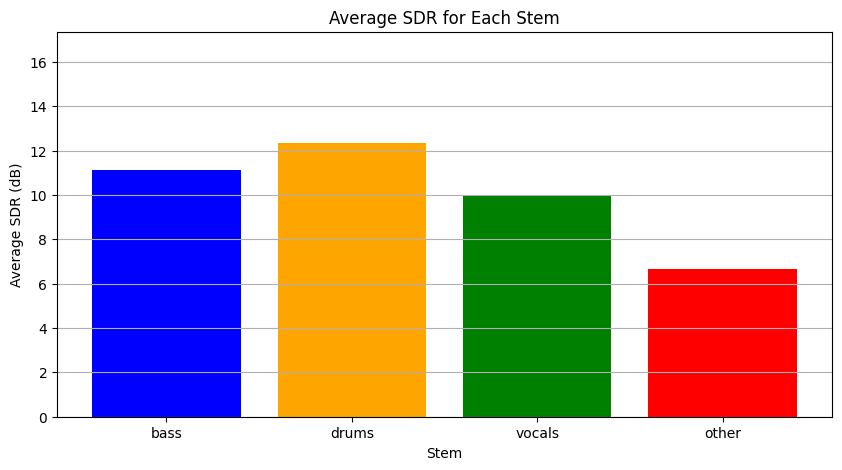

In [94]:
# Plot the SDR results
plot_sdr_results(average_sdr)